In [1]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [2]:
!pip install \
'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q roboflow supervision
!wget -q \
'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'
'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-zmsfq2uu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-zmsfq2uu
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=960653f5958b47f5d3532d93370607525e510a4551f248cc3c5d73fa24ed20db
  Stored in directory: /tmp/pip-ephem-wheel-cache-7psayjny/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

In [3]:
# === Imports ===
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
from scipy.spatial.distance import euclidean
from scipy.interpolate import splprep, splev

# === Mount Drive and Load Image ===
from google.colab import drive
drive.mount('/content/gdrive')

# === Input image path ===
image_path = "/content/gdrive/MyDrive/Flagella length/lf5/Snap-02.tif"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# === Enhance image with CLAHE ===
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced_gray = clahe.apply(gray)

# === Morphological closing ===
kernel = np.ones((5, 5), np.uint8)
closed_gray = cv2.morphologyEx(enhanced_gray, cv2.MORPH_CLOSE, kernel)

# === Prepare SAM input ===
filled_rgb = cv2.cvtColor(closed_gray, cv2.COLOR_GRAY2RGB)
# === Load SAM model ===
model_type = "vit_h"
sam_checkpoint = "sam_vit_h_4b8939.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
# === Step 4: Generate SAM masks ===
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=90,
    pred_iou_thresh=0.88,  # Tighter threshold for better boundary accuracy
    stability_score_thresh=0.92,  # Higher stability for precise detection
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=20  # Lowered to capture thin structures
)
masks = mask_generator.generate(filled_rgb)
masks = sorted(masks, key=lambda x: x['area'], reverse=True)

# === Filter large objects (2x median area) ===
areas = [m['area'] for m in masks]
median_area = np.median(areas)
filtered_masks = [m for m in masks if m['area'] <= 2 * median_area]

# === Optional visualization of SAM mask ===
white_overlay = np.zeros_like(filled_rgb)
for m in filtered_masks:
    white_overlay[m['segmentation']] = [255, 255, 255]

combined = cv2.addWeighted(filled_rgb, 0.6, white_overlay, 0.4, 0)

# plt.figure(figsize=(10, 8))
# plt.imshow(combined)
# plt.title("SAM Segmentation with Cilia-Flagella Gaps Filled")
# plt.axis("off")
# plt.show()

Mounted at /content/gdrive


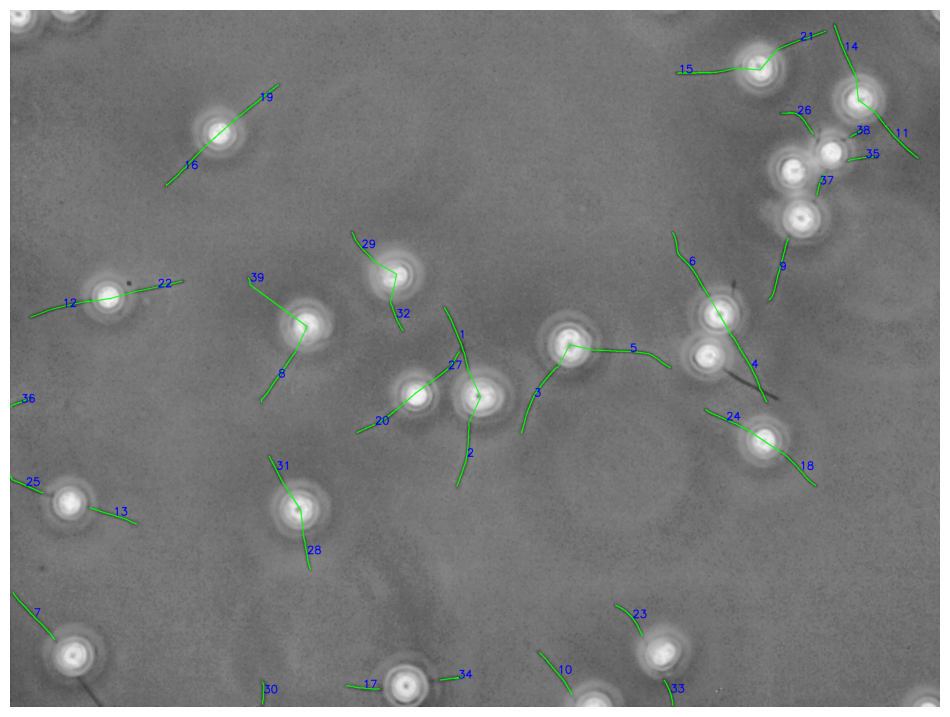

    ID      Length  Total Length
0    1  199.338095    546.991192
1    2  186.083261    546.991192
2    3  228.702889    596.686078
3    4  224.592929    564.081933
4    5  229.468037    596.686078
5    6  213.592929    564.081933
6    7  177.391919    465.635653
7    8  174.936075    468.153160
8    9  191.953319      0.000000
9   10  153.865007      0.000000
10  11  177.391919      0.000000
11  12  175.762651    406.416276
12  13  147.225397      0.000000
13  14  158.610173    465.635653
14  15  149.123106    503.843170
15  16  152.370969    473.793145
16  17   93.313708      0.000000
17  18  131.793939    385.127309
18  19  180.480675    473.793145
19  20  215.366774    470.424147
20  21  209.174412    503.843170
21  22  105.162278    406.416276
22  23  122.267027      0.000000
23  24  135.781746    385.127309
24  25  112.568542      0.000000
25  26  119.225397      0.000000
26  27  120.352203    470.424147
27  28   96.870058    350.443026
28  29  105.267027    348.370870
29  30   6

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
from scipy.spatial.distance import euclidean
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from collections import defaultdict
import pandas as pd

# === Helper: B-Spline smoothing ===
def bspline_smooth_path(path, s=3):
    if len(path) < 4:
        return path
    x = path[:, 1]
    y = path[:, 0]
    try:
        tck, u = splprep([x, y], s=s)
        u_fine = np.linspace(0, 1, 200)
        x_fine, y_fine = splev(u_fine, tck)
        smoothed_path = np.vstack((y_fine, x_fine)).T
        return smoothed_path
    except:
        return path
# === Helper: Create Results Table ===
def create_results_table(output_file, results):
    # Create a DataFrame for the table
    df = pd.DataFrame(results, columns=["ID", "Length", "Total Length"])
    # Save to a tab-separated text file
    df.to_csv(output_file, sep='\t', index=False)
    return df
# === Inputs Required ===
# filled_rgb: RGB microscopy image
# gray: grayscale version
# filtered_masks: SAM-generated flagella masks

output_img = filled_rgb.copy()
pixel_size_microns = 0.1
flagella_counter = 1
global_flagella_mask = np.zeros_like(gray, dtype=np.uint8)
center_flagella_map = defaultdict(list)
results = []  # List to store table data

# === Threshold mask for filtering internal blob-like noise ===
_, cell_mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

# === STEP 1: Detect one center per cell using DBSCAN ===
gray_blur = cv2.GaussianBlur(gray, (9, 9), 2)
detected_circles = cv2.HoughCircles(
    gray_blur,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=10,
    param1=30,
    param2=32,
    minRadius=10,
    maxRadius=40
)

final_centers = []
if detected_circles is not None:
    circles = np.uint16(np.around(detected_circles[0, :]))
    circle_points = np.array([[x, y] for (x, y, r) in circles])

    # === DBSCAN Clustering of close detections ===
    clustering = DBSCAN(eps=20, min_samples=1).fit(circle_points)
    labels = clustering.labels_

    merged_centers = []
    for cluster_id in np.unique(labels):
        cluster_indices = np.where(labels == cluster_id)[0]
        cluster_pts = circle_points[cluster_indices]
        # Average cluster center
        avg_x = int(np.mean(cluster_pts[:, 0]))
        avg_y = int(np.mean(cluster_pts[:, 1]))
        merged_centers.append((avg_x, avg_y))

    # === Additional merging of very close clusters (within 25 px)
    final_centers = []
    used = set()
    merge_distance_threshold = 25

    for i, c1 in enumerate(merged_centers):
        if i in used:
            continue
        group = [c1]
        for j, c2 in enumerate(merged_centers):
            if j != i and j not in used and np.linalg.norm(np.array(c1) - np.array(c2)) < merge_distance_threshold:
                group.append(c2)
                used.add(j)
        avg_x = int(np.mean([c[0] for c in group]))
        avg_y = int(np.mean([c[1] for c in group]))
        # Find the closest original circle to the merged center and use its radius
        closest_circle_idx = np.argmin(np.linalg.norm(circles[:, :2] - np.array([avg_x, avg_y]), axis=1))
        avg_r = circles[closest_circle_idx][2]
        final_centers.append((avg_x, avg_y, avg_r))  # include radius

# === Draw final centers ===
# for i, (x, y, r) in enumerate(final_centers):
#     # cv2.circle(output_img, (x, y), 3, (0, 0, 255), -1)
#     cv2.putText(output_img, f"C{i+1}", (x + 5, y - 5),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 1)
flagella_endpoints = []
endpoint_dist_thresh = 15  # pixels
# === STEP 2: Process Each Flagellum ===
for m in filtered_masks:
    binary_mask = m['segmentation'].astype(np.uint8) * 255
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    if np.sum(np.logical_and(global_flagella_mask > 0, binary_mask > 0)) / np.sum(binary_mask > 0) > 0.1:
        continue

    skeleton = skeletonize(binary_mask > 0).astype(np.uint8)
    skeleton_points = np.column_stack(np.where(skeleton))
    if len(skeleton_points) < 2:
        continue
    if np.sum(cell_mask[skeleton_points[:, 0], skeleton_points[:, 1]] > 0) / len(skeleton_points) > 0.5:
        continue

    # Label regions
    labeled = label(skeleton, connectivity=2)
    for region in regionprops(labeled):
        coords = region.coords
        if len(coords) < 2:
            continue
        coords = sorted(coords, key=lambda p: (p[0], p[1]))
        path = [coords[0]]
        length = 0.0
        for i in range(1, len(coords)):
            dist = euclidean(coords[i], coords[i - 1])
            if dist < 5:
                length += dist
                path.append(coords[i])
        if length < 20:
            continue

        path = np.array(path)
        # === Exclude skeletons that enter detected Hough circle region ===
        inside_circle = False
        for cx, cy, r in final_centers:
            dists = np.sqrt((path[:, 1] - cx)**2 + (path[:, 0] - cy)**2)
            if np.any(dists < r):  # inside the Hough-detected cell region
                inside_circle = True
                break
        if inside_circle:
            continue  # skip this mask entirely
        smooth_path = bspline_smooth_path(path)
        path_xy = smooth_path[:, ::-1]
        start = path_xy[0]
        end = path_xy[-1]

        # Check if start or end is too close to an already processed flagellum
        duplicate = any(
            np.linalg.norm(np.array(start) - np.array(p)) < endpoint_dist_thresh or
            np.linalg.norm(np.array(end) - np.array(p)) < endpoint_dist_thresh
            for p in flagella_endpoints
        )

        if duplicate:
            continue  # skip duplicate flagellum

        # If not duplicate, store endpoints
        flagella_endpoints.extend([start, end])

        if not final_centers:
            continue

        # Use only x and y coordinates from final_centers for distance calculation
        all_dists = [np.min(np.linalg.norm(path_xy - np.array(c[:2]), axis=1)) for c in final_centers]
        nearest_center_idx = np.argmin(all_dists)
        nearest_center = final_centers[nearest_center_idx]
        # Store flagellum length in results
        results.append([flagella_counter, length, 0.0])  # Placeholder for total length
        center_flagella_map[tuple(nearest_center[:2])].append((smooth_path, length))

        for i in range(1, len(smooth_path)):
            pt1 = tuple(np.round(smooth_path[i - 1][::-1]).astype(int))
            pt2 = tuple(np.round(smooth_path[i][::-1]).astype(int))
            cv2.line(output_img, pt1, pt2, (0, 255, 0), 2)  # green line

        midpoint = smooth_path[len(smooth_path) // 2][::-1]
        cv2.putText(output_img, f"{flagella_counter}", tuple(np.round(midpoint).astype(int)),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2)  # green text

        # global_flagella_mask = cv2.bitwise_or(global_flagella_mask, binary_mask)
        global_flagella_mask = cv2.bitwise_or(global_flagella_mask, binary_mask)
        flagella_counter += 1

# === STEP 3A: Merge Nearby Centers (<10 px) ===
merged_map = defaultdict(list)
visited = set()
merge_threshold = 25
centers = list(center_flagella_map.keys())

for i in range(len(centers)):
    if i in visited:
        continue
    base_center = np.array(centers[i])
    group = [i]
    for j in range(i + 1, len(centers)):
        if j in visited:
            continue
        other_center = np.array(centers[j])
        if np.linalg.norm(base_center - other_center) < merge_threshold:
            group.append(j)
            visited.add(j)
    merged_center = tuple(np.round(base_center).astype(int))
    for idx in group:
        merged_map[merged_center].extend(center_flagella_map[centers[idx]])

# === STEP 3B: Merge 2 Flagella Per Merged Center ===
for i, (center, flist) in enumerate(merged_map.items()):
    if len(flist) == 2:
        total_length = 0.0
        for path, length in flist:
            path_xy = path[:, ::-1]
            base_idx = np.argmin(np.linalg.norm(path_xy - np.array(center), axis=1))
            base_point = path_xy[base_idx]
            center_to_base = np.linalg.norm(np.array(center) - base_point)
            total_length += length + center_to_base
            cv2.line(output_img, tuple(np.round(center).astype(int)),
                     tuple(np.round(base_point).astype(int)), (0, 255, 0), 2)  # yellow line
 # Update total length for flagella associated with this center
        for j, (path, length) in enumerate(flist):
            # Find the corresponding flagellum ID in results
            for result in results:
                if abs(result[1] - length) < 1e-6:  # Match by length
                    result[2] = total_length
                    break

# === Save Results to File ===
table_df = create_results_table("Results.txt", results)

# === Display Final Output ===
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Print the table for verification
print(table_df)